In [1]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 13.7 MB/s 
     |████████████████████████████████| 88 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=adf40ff93669b25a10d920ca3533b1ca99213a6596b7444d38a969107e6304cc
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=989616c380be2589a634c9070e3603b39826c9cdd62269c69c3f9a9854d21ac5
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklego.mixture import BayesianGMMClassifier

In [4]:
PATH = 'drive/MyDrive/Kaggle/Clustering_072022/'

df = pd.read_csv(PATH + 'src/data_removed.csv', index_col='id')
cat_feats = df.columns[df.dtypes == 'int']
num_feats = df.columns[df.dtypes == 'float']
best_cols = df.columns

X_scaled = pd.DataFrame(PowerTransformer().fit_transform(df), columns=df.columns)

In [5]:
bgmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', n_init=3, random_state=2)
predicted_class = bgmm.fit_predict(X_scaled)
df["class"] = predicted_class

In [6]:
def score_clusters(X, predictions, silhouette = False, verbose=False):
    """Evaluate how good our cluster label predictions are"""
    
    db_score = davies_bouldin_score(X=X, labels=predictions)

    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    #the silhouette score is the slowest to compute ~90 secs
    #s_score = silhouette_score(X=X, labels=predictions, metric='euclidean')
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        #print("Silhouette score: {0:0.4f}".format(s_score))
        
    return db_score, ch_score #,s_score

In [7]:
def soft_voting(predict_number, best_cols = best_cols):
    #initialise dataframe with 0's
    predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(40000)
        gmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', max_iter=300, init_params="kmeans", n_init=3, random_state=i)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # ensuring clusters are labeled the same value at each fit
        if i == 0:
            initial_centers = gmm.means_
        new_classes = []
        for mean2 in gmm.means_:
            #for the current center of the current gmm, find the distances to every center in the initial gmm
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            # select the class with the minimum distance
            new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
        # if the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("iteration", i, "could not determine the cluster label mapping, skipping")
            continue
        #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))
        
        #add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        # lets score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    #normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [8]:
pred_probs = soft_voting(30)

========= 0 ==========
David Bouldin score: 3.6319
Calinski Harabasz score: 3795.201
========= 1 ==========
David Bouldin score: 3.6249
Calinski Harabasz score: 3801.555
========= 2 ==========
David Bouldin score: 3.6217
Calinski Harabasz score: 3803.175
========= 3 ==========
David Bouldin score: 3.6276
Calinski Harabasz score: 3804.305
========= 4 ==========
David Bouldin score: 3.6277
Calinski Harabasz score: 3803.285
========= 5 ==========
iteration 5 could not determine the cluster label mapping, skipping
========= 6 ==========
David Bouldin score: 3.6296
Calinski Harabasz score: 3803.410
========= 7 ==========
David Bouldin score: 3.6357
Calinski Harabasz score: 3806.657
========= 8 ==========
David Bouldin score: 3.6328
Calinski Harabasz score: 3808.909
========= 9 ==========
David Bouldin score: 3.6358
Calinski Harabasz score: 3806.286
========= 10 ==========
iteration 10 could not determine the cluster label mapping, skipping
========= 11 ==========
David Bouldin score: 3.6336

In [9]:
%%time
score_clusters(X_scaled[best_cols],pred_probs.idxmax(axis=1), verbose=True, silhouette = False)

David Bouldin score: 3.6277
Calinski Harabasz score: 3811.090
CPU times: user 253 ms, sys: 282 ms, total: 534 ms
Wall time: 213 ms


(3.627651141568523, 3811.0898047236865)

In [10]:
def best_class(df):
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"] = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"] = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0]+1, axis=1)
    return new_df

In [11]:
cluster_class_probs = best_class(pred_probs)

In [12]:
cluster_class_probs.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,0.003467,0.002669,0.000489,0.003499,5.493692e-07,0.977578,0.012298,0.977578,6,0.012298,7
1,0.000013,0.025283,0.003512,0.017420,1.373030e-02,0.000334,0.939708,0.939708,7,0.025283,2
2,0.180896,0.000016,0.001415,0.000108,1.182848e-08,0.817157,0.000408,0.817157,6,0.180896,1
3,0.091272,0.010926,0.026393,0.000047,8.561897e-01,0.000017,0.015156,0.856190,5,0.091272,1
4,0.000011,0.000003,0.979699,0.000179,8.652745e-07,0.000005,0.020102,0.979699,3,0.020102,7


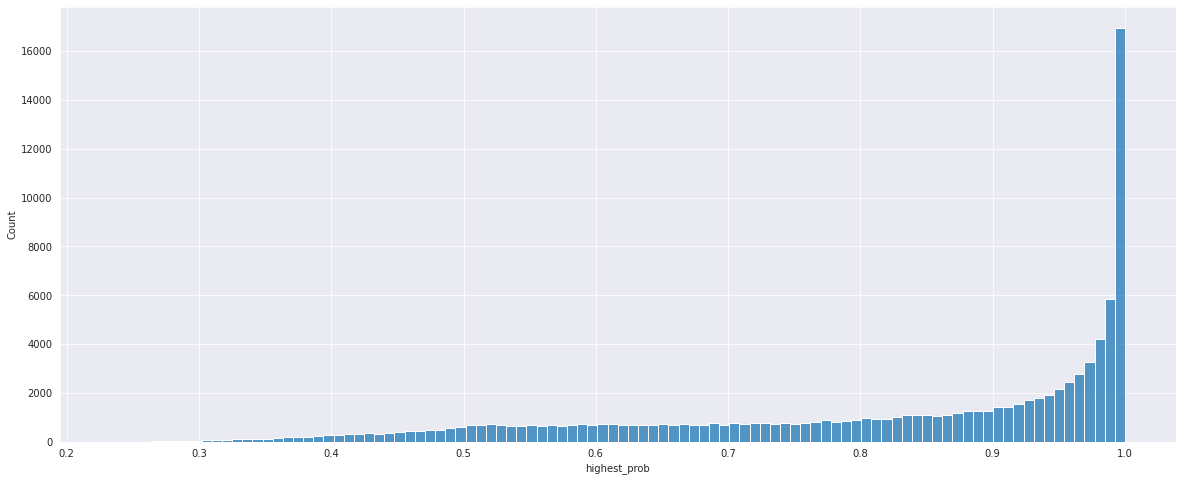

In [13]:
plt.figure(figsize=(20, 8))
sns.histplot(cluster_class_probs['highest_prob'], bins=100)

(0.65, 0.95)

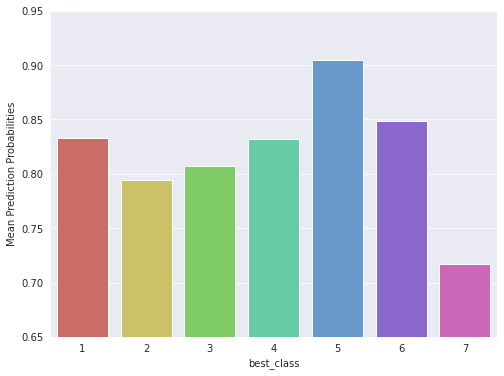

In [14]:
confidence_s = cluster_class_probs.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Prediction Probabilities')
ax.set_ylim([0.65, 0.95])

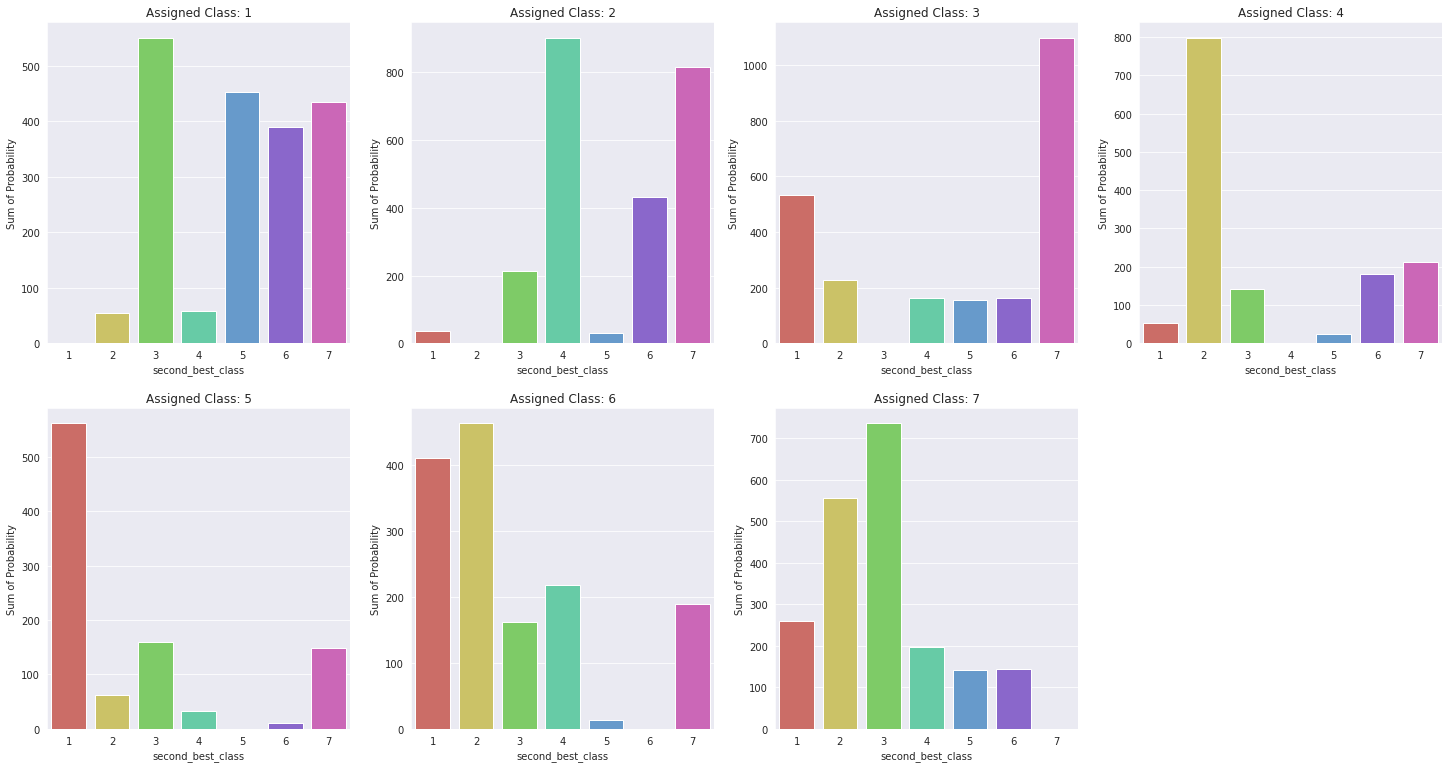

In [15]:
second_highest_probs_sum = cluster_class_probs.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()

fig, ax = plt.subplots(figsize=(25, 13))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})
for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class']==i, ['second_best_class', 'second_highest_prob']]
    plot_df = pd.merge(left=tmp_df, right=second_best_match, on='second_best_class', how='left')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plot_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Sum of Probability')
    ax.set_title('Assigned Class: ' + str(i))

In [16]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs['highest_prob'] >= 0.85]
confident_preds_class = confident_predictions['best_class']
X_scaled['class'] = confident_preds_class

In [17]:
train_df = X_scaled.loc[X_scaled["class"] == X_scaled["class"]]
test_df = X_scaled.loc[X_scaled["class"] != X_scaled["class"]]

In [18]:
X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = X_scaled.drop(columns="class")

In [19]:
et = ExtraTreesClassifier(n_estimators = 2000,
                                n_jobs = -1,
                                random_state=42
                               )

In [20]:
lgb = LGBMClassifier(objective = 'multiclass',
                            n_estimators = 5000,
                            random_state = 42,
                            learning_rate = 0.1,
                            n_jobs = -1)

In [21]:
qda = QuadraticDiscriminantAnalysis()
lda = LinearDiscriminantAnalysis()

In [22]:
bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state = 1,
            tol =1e-3,
            covariance_type = 'full',
            max_iter = 400,
            n_init=4,
            init_params='kmeans')

In [23]:
models = {"ET":et, "LGBM":lgb, "QDA":qda, "LDA":lda, "BGMM_C":bgmm}

In [24]:
def k_fold_cv(model, X, y, verbose=True):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    feat_imp, y_pred_list, y_true_list, acc_list = [], [], [], []
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(X, y)):
        if verbose: print('=========='*10+f'\n Fold number: {fold}')
        X_train = X.loc[trn_idx]
        X_val = X.loc[val_idx]

        y_train = y.loc[trn_idx]
        y_val = y.loc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list =- np.append(y_true_list, y_val)

        acc_list.append(accuracy_score(y_pred, y_val))
        if verbose: print(f'Accuracy Score: {acc_list[-1]}')
        try:
            feat_imp.append(model.feature_importances_)
        except AttributeError:
            pass

    return feat_imp, y_pred_list, y_true_list, acc_list, X_val, y_val

In [25]:
def evaluate_models():
    for model_name, model in models.items():
        print(f'==='*10, model_name, '==='*10)
        feat_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model, X=X, y=y, verbose=True)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print('{0:0.4f}'.format(acc_score))

In [26]:
evaluate_models()

============================== ET ==============================
 Fold number: 0
Accuracy Score: 0.9885171790235081
 Fold number: 1
Accuracy Score: 0.9874321880650995
 Fold number: 2
Accuracy Score: 0.9880650994575045
 Fold number: 3
Accuracy Score: 0.9884267631103074
 Fold number: 4
Accuracy Score: 0.9871609403254973
0.3952
============================== LGBM ==============================
 Fold number: 0
Accuracy Score: 0.9976491862567812
 Fold number: 1
Accuracy Score: 0.9970162748643762
 Fold number: 2
Accuracy Score: 0.9972875226039783
 Fold number: 3
Accuracy Score: 0.9981012658227848
 Fold number: 4
Accuracy Score: 0.9971066907775769
0.3990
============================== QDA ==============================
 Fold number: 0
Accuracy Score: 0.9999095840867993
 Fold number: 1
Accuracy Score: 0.9999095840867993
 Fold number: 2
Accuracy Score: 1.0
 Fold number: 3
Accuracy Score: 1.0
 Fold number: 4
Accuracy Score: 0.9999095840867993
0.4000
============================== LDA ===========

In [27]:
feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=lgb,X=X,y=y)

 Fold number: 0
Accuracy Score: 0.9976491862567812
 Fold number: 1
Accuracy Score: 0.9970162748643762
 Fold number: 2
Accuracy Score: 0.9972875226039783
 Fold number: 3
Accuracy Score: 0.9981012658227848
 Fold number: 4
Accuracy Score: 0.9971066907775769


In [28]:
def plot_feature_importances(model_importances, feature_names, model_name, n_folds=5, ax=None, boxplot=False):
    importances_df = pd.DataFrame({'feature_cols': feature_names, 'importances_fold_0': model_importances[0]})
    for i in range(1, n_folds):
        importances_df[f'importances_fold_{i}'] = model_importances[i]
    importances_df['importances_fold_median'] = importances_df.drop('feature_cols', axis=1).median(axis=1)
    importances_df = importances_df.sort_values(by='importances_fold_median', ascending=False)
    if ax == None:
        fig, ax = plt.subplots(figsize=(15, 25))
    if boxplot == False:
        ax = sns.barplot(data=importances_df, x='importances_fold_median', y='feature_cols', color='blue')
        ax.set_xlabel('Median Feature Importance Across Folds')
    elif boxplot == True:
        importances_df = importances_df.drop('importances_fold_median', axis=1)
        importances_df = importances_df.set_index('feature_cols').stack().reset_index().rename(columns={0: 'feature_importance'})
        ax = sns.boxplot(data=importances_df, y='feature_cols', x='feature_importance', color='blue', orient='h')
        ax.set_xlabel('Feature Importance Across Folds')
    plt.title(model_name)
    ax.set_ylabel('Feature Names')
    return ax

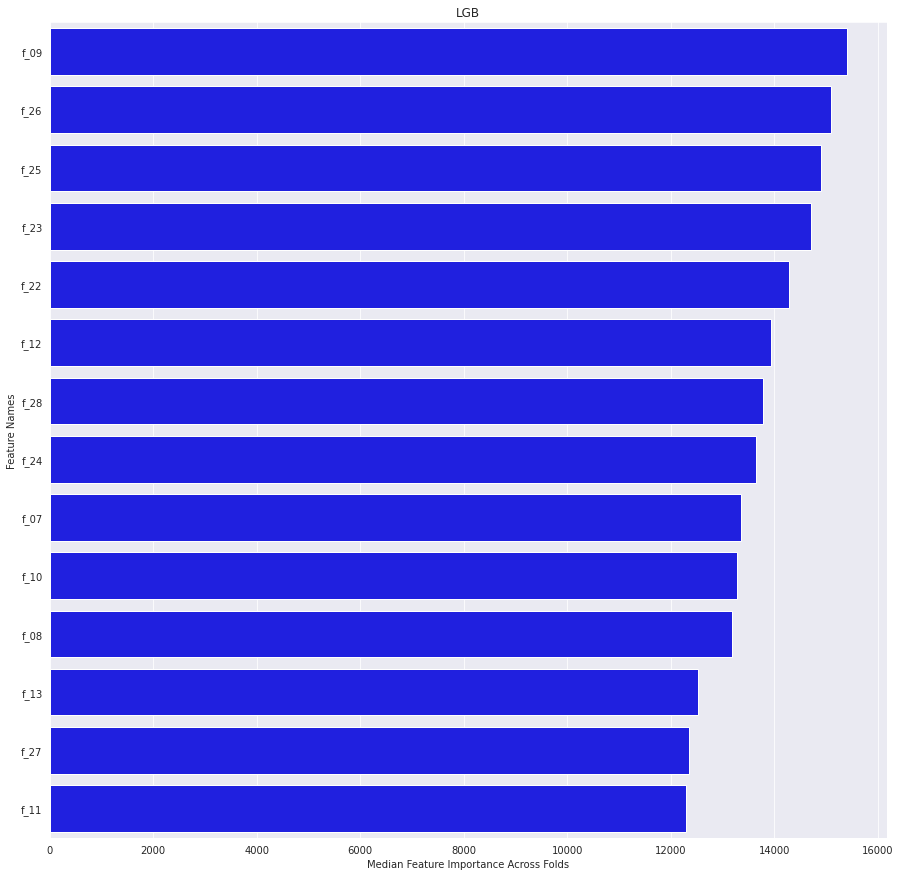

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_feature_importances(model_importances=feature_imp, feature_names=X_val.columns, model_name='LGB', n_folds=2, ax=ax, boxplot=False)

# Inference

In [30]:
def fit_predict_everything():
    preds = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print('===', model_name, '===')
        model.fit(X[best_cols], y)
        preds_prob = model.predict_proba(X_full[best_cols])
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1, 8), index=X_scaled.index)
        db, ch = score_clusters(X_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db, ch))
        preds.append(preds_prob_df)
        model_names.append(model_name)

    return preds, model_names, scores


In [31]:
predictions, model_names, scores = fit_predict_everything()

=== ET ===
David Bouldin score: 3.4147
Calinski Harabasz score: 4004.455
=== LGBM ===
David Bouldin score: 3.5682
Calinski Harabasz score: 3902.171
=== QDA ===
David Bouldin score: 3.5391
Calinski Harabasz score: 3925.696
=== LDA ===
David Bouldin score: 3.0773
Calinski Harabasz score: 4617.374
=== BGMM_C ===
David Bouldin score: 3.6099
Calinski Harabasz score: 3839.143


In [32]:
cluster_class_probs = cluster_class_probs.loc[:, [1, 2, 3, 4, 5, 6, 7]]
predictions.append(cluster_class_probs)
model_names.append('BGMM')

In [33]:
db, ch = score_clusters(X_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db, ch))

David Bouldin score: 3.6277
Calinski Harabasz score: 3811.090


In [34]:
#chosen fairly randomly
predictions_df = 0.5 * predictions[0] + 1.5 * predictions[1] + 0.5 * predictions[2] + 1.5 * predictions[4] + 0.5 * predictions[5]

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)

In [35]:
db, ch = score_clusters(X_scaled[best_cols], predictions_df["best_class"], verbose=True)
scores.append((db,ch))
model_names.append("combined")

David Bouldin score: 3.5540
Calinski Harabasz score: 3915.617


In [37]:
pd.DataFrame(scores, index=model_names, columns=["Davies-Bouldin Index","Calinski-Harabasz Index"])

,Davies-Bouldin Index,Calinski-Harabasz Index
ET,3.414714,4004.454589
LGBM,3.568167,3902.171119
QDA,3.539057,3925.696402
LDA,3.077324,4617.374349
BGMM_C,3.609902,3839.142674
BGMM,3.627651,3811.089805
combined,3.554007,3915.616729


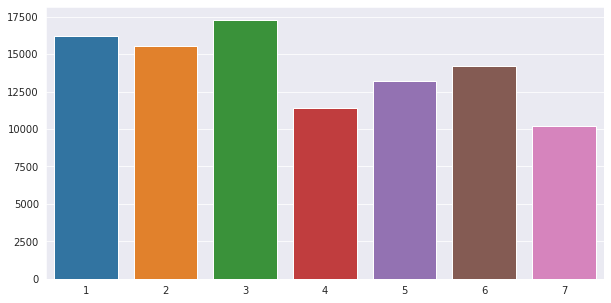

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)

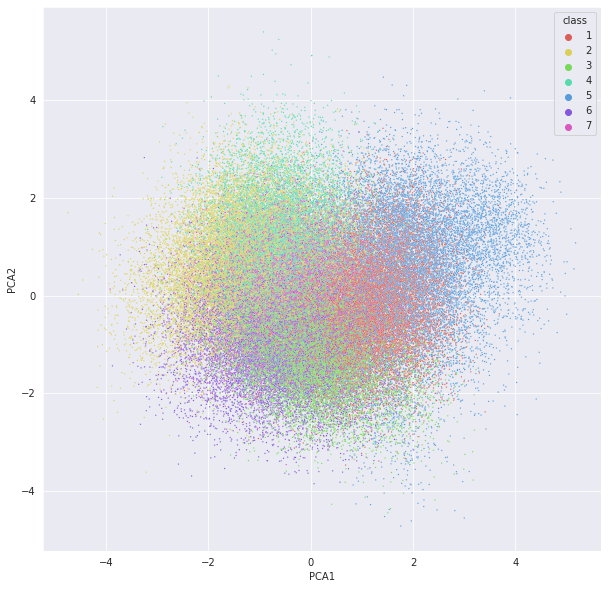

In [39]:
pca = PCA(n_components=2, random_state=10)
X_pca = pca.fit_transform(X_scaled[best_cols])
pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1]})
pca_df['class'] = predictions_df['best_class']

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', s=2, palette=sns.color_palette('hls', pca_df['class'].nunique()))

(0.4, 0.95)

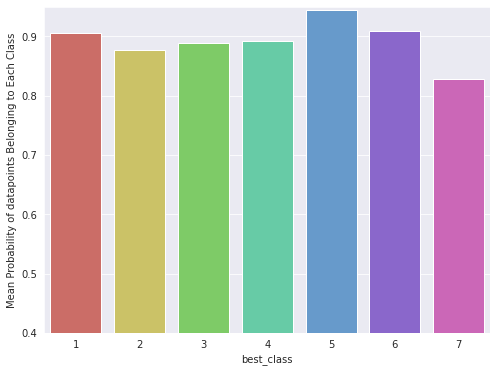

In [40]:
confidence_s = predictions_df.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Probability of datapoints Belonging to Each Class')
ax.set_ylim([0.4, 0.95])

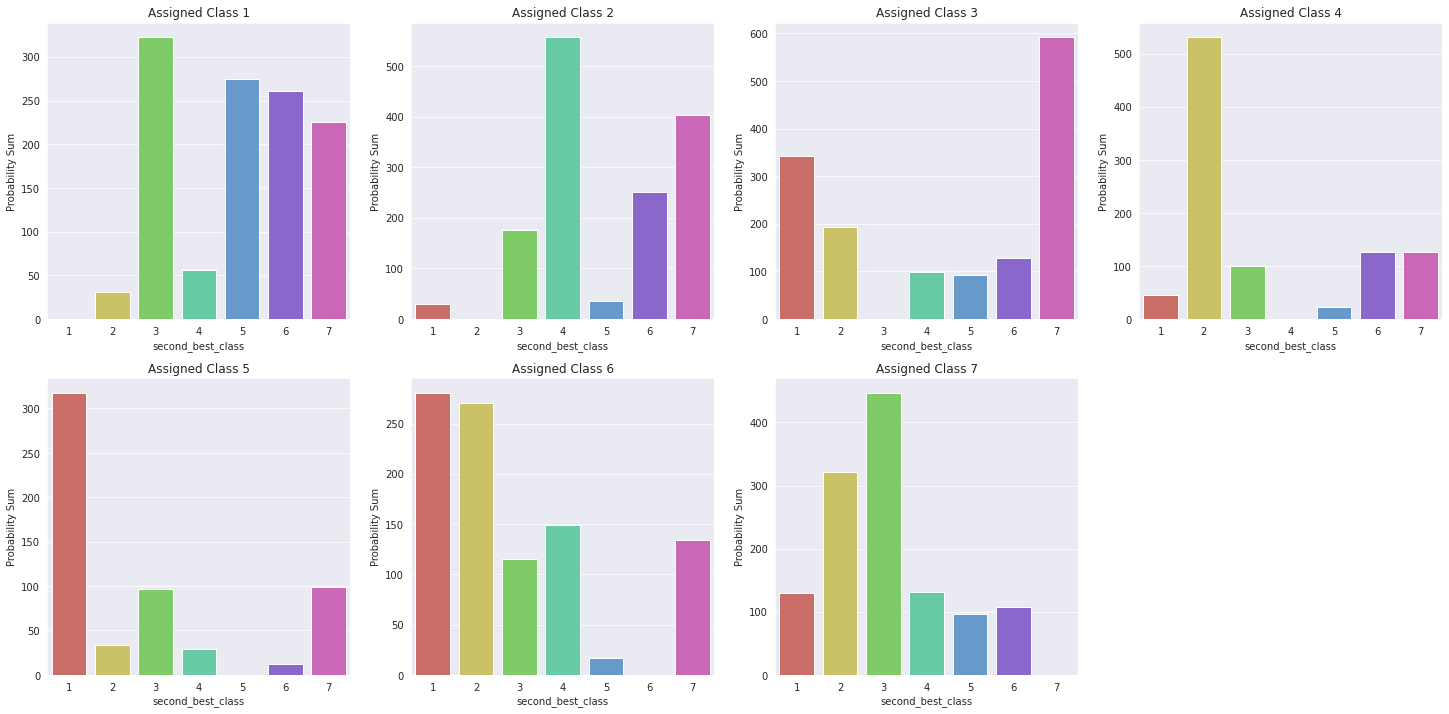

In [42]:
second_highest_probs_sum = predictions_df.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()
fig, ax = plt.subplots(figsize=(25, 12))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})

for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class'] == i, ['second_best_class', 'second_highest_prob']]
    plt_df = pd.merge(left=tmp_df, right=second_best_match, how='left', on='second_best_class')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plt_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Probability Sum')
    ax.set_title(f'Assigned Class {i}')

In [43]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print('==='*6, i, '==='*6)
        X_scaled_sample = X_scaled.sample(60000)
        y_sample = y.loc[X_scaled_sample.index]

        bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state=i,
            n_init=3, max_iter=300,
            tol=0.001,
            init_params='kmeans'
        )
        bgmm.fit(X_scaled_sample[best_cols], y_sample)

        pred_probs = bgmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))

        score_clusters(X_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)

    return pred_probs

In [44]:
predicted_probabilities = update_predictions(predict_number=25, y=predictions_df["best_class"])

================== 0 ==================
David Bouldin score: 3.6345
Calinski Harabasz score: 3785.487
================== 1 ==================
David Bouldin score: 3.6924
Calinski Harabasz score: 3694.024
================== 2 ==================
David Bouldin score: 3.7522
Calinski Harabasz score: 3630.967
================== 3 ==================
David Bouldin score: 3.7915
Calinski Harabasz score: 3595.432
================== 4 ==================
David Bouldin score: 3.8154
Calinski Harabasz score: 3568.868
================== 5 ==================
David Bouldin score: 3.8327
Calinski Harabasz score: 3556.266
================== 6 ==================
David Bouldin score: 3.8466
Calinski Harabasz score: 3543.283
================== 7 ==================
David Bouldin score: 3.8581
Calinski Harabasz score: 3534.297
================== 8 ==================
David Bouldin score: 3.8669
Calinski Harabasz score: 3527.159
================== 9 ==================
David Bouldin score: 3.8655
Calinski Harab

In [45]:
predictions_df = best_class(predicted_probabilities)

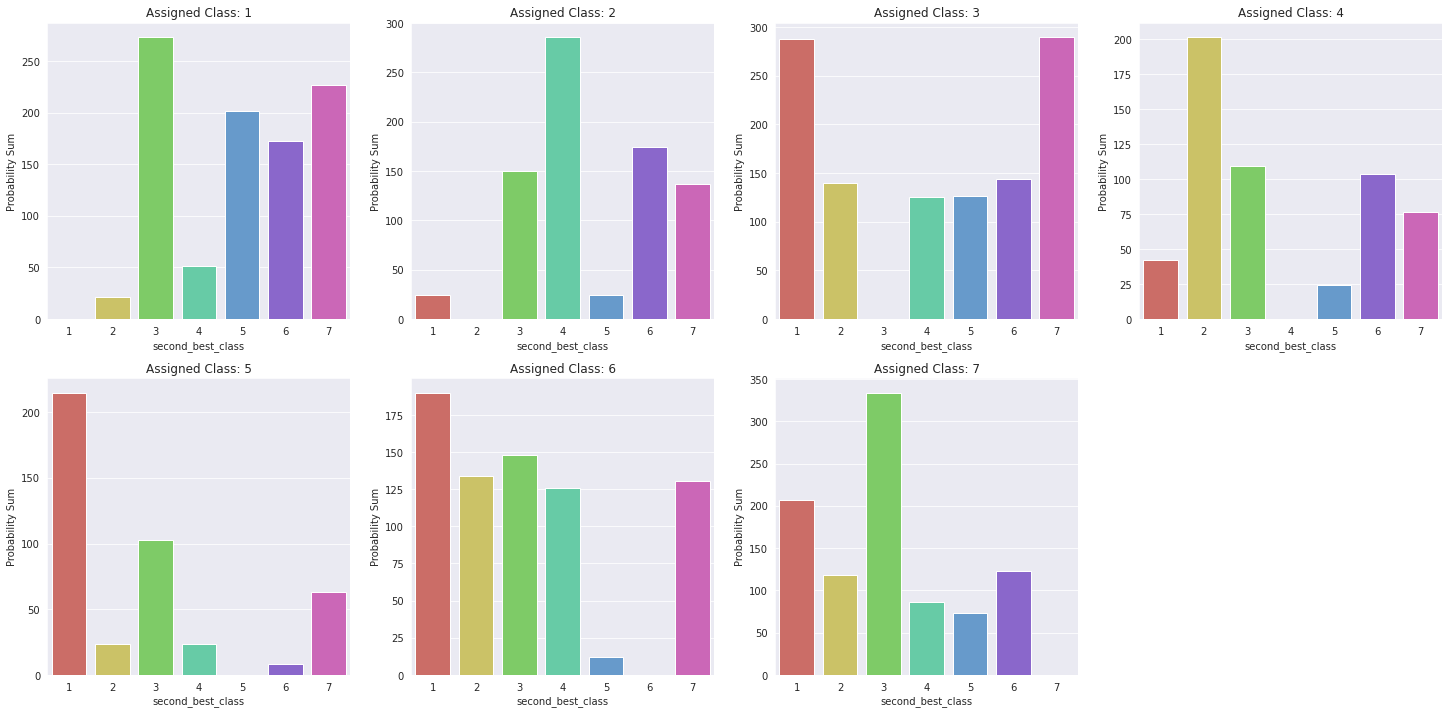

In [47]:
second_highest_probs_sum = predictions_df.groupby(['best_class', 'second_best_class'])['second_highest_prob'].sum().reset_index()

fig, ax = plt.subplots(figsize=(25, 12))
tmp_df = pd.DataFrame({'second_best_class': range(1, 8)})
for i in range(1, 8):
    second_best_match = second_highest_probs_sum.loc[second_highest_probs_sum['best_class'] == i, ['second_best_class', 'second_highest_prob']]
    plot_df = pd.merge(left=tmp_df, right=second_best_match, how='left', on='second_best_class')
    ax = plt.subplot(2, 4, i)
    sns.barplot(data=plot_df, x='second_best_class', y='second_highest_prob', palette=sns.color_palette('hls', 7))
    ax.set_ylabel('Probability Sum')
    ax.set_title(f'Assigned Class: {i}')

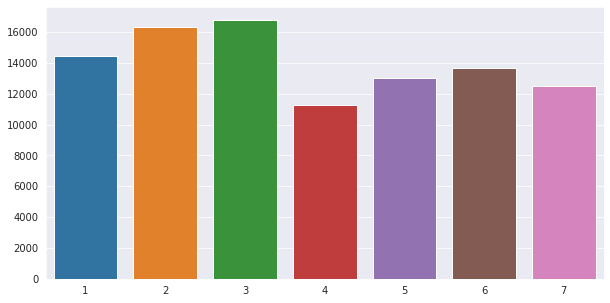

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
val_c = predictions_df['best_class'].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)

In [49]:
submission = pd.read_csv(PATH + 'submissions/sample_submission.csv', index_col='Id')
submission['Predicted'] = predictions_df['best_class']
submission.to_csv(PATH + 'submissions/ensemble#2.csv')